In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Checking the Available GPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')
print(device)

GPU
cuda:0


In [14]:
# Downloading the Data and Splitting it into (Training and Validation Sets)

transform = transforms.Compose([transforms.ToTensor()])

data = FashionMNIST(root = 'data/', train = True, download = True, transform = transform)
# test_data = MNIST(root = 'datasets/MNIST', train = False, download = True, transform = transform)

val_data_size = 10000
train_data_size = len(data) - val_data_size

train_data, val_data = random_split(data, [train_data_size, val_data_size])


print(len(train_data), len(val_data))

50000 10000


In [15]:
# Creating Batches of Training and Validation Data

batch_size = 128
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)
print(len(val_loader))

79


Printing a Grid of Batch Images



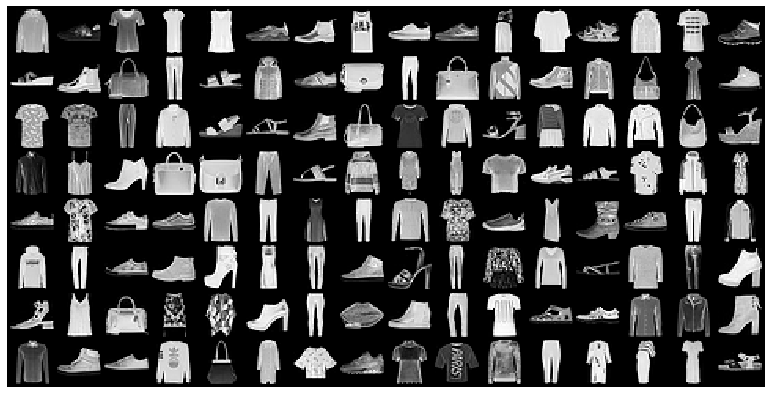

In [16]:
# Visualizing Batch of Training Data into a Grid using make_grid() Function

for images, labels in train_loader:
    print('Printing a Grid of Batch Images\n')
    plt.figure(figsize = (16,7))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
    break

# Model Related Functions

In [17]:
# Accuarcy Function
def accuracy_function(outputs, labels):
    _, index = torch.max(outputs, dim = 1)
    return torch.tensor((index == labels).sum().item() / len(labels))

# NN Class
class NNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, X):
        X = X.view(X.size(0), -1)
        out = F.relu(self.layer1(X))
        out = self.layer2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        accuracy = accuracy_function(outputs, labels)
        return  loss, {'Train_Loss_Value' : loss, 'Train_Accuracy_Value' : accuracy}
    
    def validation_step(self,  batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = self.forward(images)
        loss = F.cross_entropy(outputs, labels)
        accuracy = accuracy_function(outputs, labels)
        return {'Val_Loss_Value' : loss, 'Val_Accuracy_Value' : accuracy}
    
    def validation_log_at_the_end_of_epoch(self, val_model_log):
        loss = [data['Val_Loss_Value'] for data in val_model_log]
        accum_loss = torch.stack(loss).mean()
        acc = [data['Val_Accuracy_Value'] for data in val_model_log]
        accum_acc = torch.stack(acc).mean()
        return {'Val_Mean_Epoch_Loss': accum_loss.item(), 'Val_Mean_Epoch_Accuracy': accum_acc.item()}
    
    def train_log_at_the_end_of_epoch(self, train_model_log):
        loss = [data['Train_Loss_Value'] for data in train_model_log]
        accum_loss = torch.stack(loss).mean()
        acc = [data['Train_Accuracy_Value'] for data in train_model_log]
        accum_acc = torch.stack(acc).mean()
        return {'Train_Mean_Epoch_Loss': accum_loss.item(), 'Train_Mean_Epoch_Accuracy': accum_acc.item()}
        
    def model_log_at_the_end_of_epoch(self, epoch, Train_history, Val_history):
        print(f"Epoch : {epoch}, Train Loss : {Train_history['Train_Mean_Epoch_Loss']}, Train Accuracy : {Train_history['Train_Mean_Epoch_Accuracy']}, Val Loss : {Val_history['Val_Mean_Epoch_Loss']}, Val Accuracy : {Val_history['Val_Mean_Epoch_Accuracy']}")   

In [18]:
# # Experimenting Cell
# import numpy as np

# a = np.array([{'val':3, 'loss': 10},{'val':4, 'loss': 11},{'val':5, 'loss': 12},{'val':6, 'loss': 13}])
# x = [i['val'] for i in a]
# x = np.array(x)
# npx = np.array(x)
# tens = torch.tensor(x)
# print(type(tens), tens.shape)
# tens = tens.reshape(tens.shape[0], 1)
# print(type(tens), tens.shape)
# val = torch.stack(tens)

In [19]:
# Initializing the Model

# Hyper-Parameter Settings
input_size = 784
hidden_size = 32
output_size = 10
lr = 0.01

model = NNet(input_size, hidden_size, output_size).to(device)

In [20]:
# Initializing the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Inspecting the size of the Model Parmaters
for params in model.parameters():
    print(params.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [21]:
# Predicting Outputs from the Initial Model Parameters
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model.forward(images)
    loss = F.cross_entropy(outputs, labels)
    break

print(f'Loss of Single Batch is : {loss.item()}')    
print(f'Output Shape is : {outputs.shape}')
print(f'Predicted Output is {outputs[:2].data}')

Loss of Single Batch is : 2.2918317317962646
Output Shape is : torch.Size([128, 10])
Predicted Output is tensor([[ 0.2567,  0.0684, -0.0448,  0.3788, -0.0933,  0.2132, -0.0376,  0.0750,
         -0.1092,  0.0652],
        [ 0.0534,  0.0290,  0.0315,  0.1353, -0.0348,  0.1076,  0.0063,  0.1303,
         -0.1286, -0.0297]], device='cuda:0')


# Training Loop

In [22]:
# Evaluate Function
def evaluation(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_log_at_the_end_of_epoch(outputs)

num_epochs = 10
train_history = []
val_history = []

def Training(model, optimizer, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        losses = []
        log = dict()
        for batch in train_loader:
            # Forward Prop
            loss, log = model.training_step(batch)
            losses.append(log)
            # Backward Prop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_batch_results = model.train_log_at_the_end_of_epoch(losses)
        results = evaluation(model, val_loader)
        model.model_log_at_the_end_of_epoch(epoch, train_batch_results, results)
        train_history.append(train_batch_results)
        val_history.append(results)
        losses = []
    return (train_history, val_history)

In [23]:
# Checking the Evaluate Function
log = [evaluation(model, val_loader)]
log

[{'Val_Mean_Epoch_Loss': 2.3109920024871826,
  'Val_Mean_Epoch_Accuracy': 0.10947389155626297}]

In [24]:
history = Training(model, optimizer, num_epochs, train_loader, val_loader)

Epoch : 0, Train Loss : 0.5624507665634155, Train Accuracy : 0.8002357482910156, Val Loss : 0.45691943168640137, Val Accuracy : 0.8456289768218994
Epoch : 1, Train Loss : 0.42583760619163513, Train Accuracy : 0.8480298519134521, Val Loss : 0.46720534563064575, Val Accuracy : 0.8276305198669434
Epoch : 2, Train Loss : 0.3969721496105194, Train Accuracy : 0.8576206564903259, Val Loss : 0.38742882013320923, Val Accuracy : 0.8624406456947327
Epoch : 3, Train Loss : 0.3772686719894409, Train Accuracy : 0.8633591532707214, Val Loss : 0.39262449741363525, Val Accuracy : 0.8607594966888428
Epoch : 4, Train Loss : 0.3658950626850128, Train Accuracy : 0.8663803339004517, Val Loss : 0.4155034124851227, Val Accuracy : 0.8585838675498962
Epoch : 5, Train Loss : 0.3518061935901642, Train Accuracy : 0.8715752959251404, Val Loss : 0.3969782292842865, Val Accuracy : 0.8601661324501038
Epoch : 6, Train Loss : 0.3454264998435974, Train Accuracy : 0.8745684027671814, Val Loss : 0.40766268968582153, Val Ac

In [25]:
len(history[0])

10

In [26]:
history = Training(model, optimizer, 5, train_loader, val_loader)

Epoch : 0, Train Loss : 0.32521161437034607, Train Accuracy : 0.8808783292770386, Val Loss : 0.3754456639289856, Val Accuracy : 0.8656052350997925
Epoch : 1, Train Loss : 0.32832589745521545, Train Accuracy : 0.8781969547271729, Val Loss : 0.3954259157180786, Val Accuracy : 0.8684731125831604
Epoch : 2, Train Loss : 0.31436967849731445, Train Accuracy : 0.8836396932601929, Val Loss : 0.4009365737438202, Val Accuracy : 0.859375
Epoch : 3, Train Loss : 0.3157772421836853, Train Accuracy : 0.8825088143348694, Val Loss : 0.370961993932724, Val Accuracy : 0.876186728477478
Epoch : 4, Train Loss : 0.30889174342155457, Train Accuracy : 0.8856977224349976, Val Loss : 0.38761600852012634, Val Accuracy : 0.8653085231781006


In [27]:
len(history[0])

15

# Plotting the Loss and Accuracy

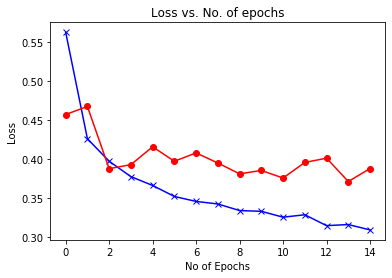

In [28]:
# Plotting Training and Validation Loss

train_loss = [l['Train_Mean_Epoch_Loss'] for l in history[0]]
val_loss   = [l['Val_Mean_Epoch_Loss'] for l in history[1]]
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, '-x', color = 'b')
plt.plot(val_loss, '-o', color = 'r')
plt.title('Loss vs. No. of epochs');

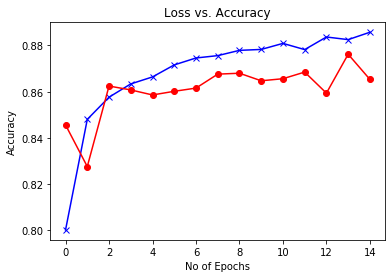

In [29]:
# Plotting Training and Validation Accuracy

train_loss = [l['Train_Mean_Epoch_Accuracy'] for l in history[0]]
val_loss   = [l['Val_Mean_Epoch_Accuracy'] for l in history[1]]
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.plot(train_loss, '-x', color = 'b')
plt.plot(val_loss, '-o', color = 'r')
plt.title('Loss vs. Accuracy');

# Commiting the Model and Parameters

In [30]:
# Saving and Uploading Model and Parameters
checkpoint = {'model_state_dict':model.state_dict(), 'optimizer.state_dict':optimizer.state_dict()}
FILE = 'FASHION_MNIST_CHECKPOINT.pth'
torch.save(checkpoint, FILE)

In [31]:
!pip install jovian --upgrade --quiet
import jovian

You should consider upgrading via the 'pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [32]:
project_name = 'Fashion_MNIST_Feed_Forward'
jovian.commit(filename =  project_name, environment = None, outputs = [checkpoint])


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "aqibjaved0910/fashion-mnist-feed-forward" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


TypeError: stat: path should be string, bytes, os.PathLike or integer, not dict